# Dados de Precipitação da Rede Hidrometeorológica Nacional

## Precipitação Média na Bacia

Trabalhando com os dados da Rede Hidrometeorológica Nacional, da Agência Nacional de Águas (ANA).

## Importando bibliotecas

In [1]:
import requests
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import seaborn as sns
from shapely import geometry, ops
import fiona
import geopandas as gpd
from datetime import datetime, timedelta
from calendar import monthrange
import statsmodels.api as sm
from scipy import stats
from shapely.geometry import Polygon
from shapely.prepared import prep
import json

In [2]:
# # Atualizar o Google Download
# !pip install --upgrade --no-cache-dir gdown

Baixar o arquivo com todos os shapefiles criados no notebook Aula 09c

* bacia
* hidro
* pluvio_sel
* exuto

https://drive.google.com/file/d/1ng26-3zXXmMUmhqA_DJueTb7nH4VgNKI/view?usp=sharing

In [3]:
!gdown 1ng26-3zXXmMUmhqA_DJueTb7nH4VgNKI

Downloading...
From: https://drive.google.com/uc?id=1ng26-3zXXmMUmhqA_DJueTb7nH4VgNKI
To: /content/shapefiles_pluvio_sel.zip
100% 1.31M/1.31M [00:00<00:00, 34.5MB/s]


In [4]:
!unzip shapefiles_pluvio_sel.zip

Archive:  shapefiles_pluvio_sel.zip
   creating: content/shapefiles/
   creating: content/shapefiles/exuto/
  inflating: content/shapefiles/exuto/exuto.dbf  
  inflating: content/shapefiles/exuto/exuto.prj  
  inflating: content/shapefiles/exuto/exuto.shp  
  inflating: content/shapefiles/exuto/exuto.shx  
 extracting: content/shapefiles/exuto/exuto.cpg  
   creating: content/shapefiles/pluvio/
  inflating: content/shapefiles/pluvio/pluvio_sel.prj  
  inflating: content/shapefiles/pluvio/pluvio_sel.dbf  
  inflating: content/shapefiles/pluvio/pluvio_sel.shx  
  inflating: content/shapefiles/pluvio/pluvio_sel.shp  
 extracting: content/shapefiles/pluvio/pluvio_sel.cpg  
   creating: content/shapefiles/bacia/
  inflating: content/shapefiles/bacia/bacia.shx  
 extracting: content/shapefiles/bacia/bacia.cpg  
  inflating: content/shapefiles/bacia/bacia.dbf  
  inflating: content/shapefiles/bacia/bacia.prj  
  inflating: content/shapefiles/bacia/bacia.shp  
   creating: content/shapefiles/h

In [5]:
exuto = gpd.read_file('content/shapefiles/exuto/exuto.shp')
pluvio_sel = gpd.read_file('content/shapefiles/pluvio/pluvio_sel.shp')
bacia = gpd.read_file('content/shapefiles/bacia/bacia.shp')
hidro = gpd.read_file('content/shapefiles/hidro/hidro.shp')

## Fazer o download dos dados das estações

* Restaram 8 pluviômetros

Após o tratamento do CSV (notebook da Aula 09b), verificação e preenchimento das falhas (notebooks Aula 09c e Aula09d)

Copiar e colar o arquivo CSV no seu Google Drive, compartilhar com 'qualquer pessoa com o link' e copir o link:

Importando os dados de precipitação

* prec_8_pluv_sem_falhas.csv - https://drive.google.com/file/d/1I8JTe9Rs-tqnjzqFLHOUWXzgBV0r6-bm/view?usp=sharing

In [6]:
# Extrair do link o código no meio das barras e fazer o download no servidor do google
!gdown 1I8JTe9Rs-tqnjzqFLHOUWXzgBV0r6-bm

Downloading...
From: https://drive.google.com/uc?id=1I8JTe9Rs-tqnjzqFLHOUWXzgBV0r6-bm
To: /content/prec_8_pluv_sem_falhas.csv
100% 504k/504k [00:00<00:00, 41.4MB/s]


In [7]:
# leitura dos dados com pandas
df_pluv = pd.read_csv('prec_8_pluv_sem_falhas.csv')

print(len(df_pluv))

df_pluv['data'] = pd.to_datetime(df_pluv["data"])
df_pluv = df_pluv.set_index('data')

11323


In [8]:
# Baixa dados da base CABra
!gdown 16Ey3eavHOkWiU7g5xpG1g8Mq87vuFsh4

Downloading...
From: https://drive.google.com/uc?id=16Ey3eavHOkWiU7g5xpG1g8Mq87vuFsh4
To: /content/CABra_1_climate+streamflow_edit.csv
100% 904k/904k [00:00<00:00, 24.8MB/s]


In [9]:
# leitura dos dados com pandas
df_cabra = pd.read_csv('CABra_1_climate+streamflow_edit.csv')
df_cabra['data'] = pd.to_datetime(df_cabra['data'])
df_cabra = df_cabra.set_index('data')
df_cabra

,p_ens(mm),tmin_ens(oC),tmax_ens(oC),rh_ens(%),wnd_ens(m/s),srad_ens(MJm-2),et_ens(mm),pet_pm(mm),pet_pt(mm),pet_hg(mm),Streamflow(m3/s)
data,,,,,,,,,,,
1980-10-01,4.669,22.521,31.019,85.222,0.694,17.078,3.777,4.381,5.276,4.199,1165.800
1980-10-02,11.884,22.645,31.321,82.020,0.760,15.329,4.022,4.040,4.781,3.780,1181.200
1980-10-03,9.195,22.308,30.400,86.096,0.615,15.450,4.173,3.985,4.791,3.761,1194.400
1980-10-04,9.348,21.887,30.540,85.902,0.691,15.414,3.898,4.003,4.778,3.745,1201.000
1980-10-05,14.407,19.680,26.941,88.454,1.502,11.080,2.477,3.103,3.475,2.521,1203.200
...,...,...,...,...,...,...,...,...,...,...,...
2010-09-26,1.146,23.299,34.851,71.702,1.472,21.459,3.495,5.956,6.675,5.541,938.606
2010-09-27,0.545,22.975,35.614,68.785,1.633,23.953,3.689,6.683,7.431,6.214,933.871
2010-09-28,0.289,24.676,36.276,63.917,1.830,23.573,3.364,6.664,7.406,6.268,931.509


In [ ]:
#df_pluv = df_pluv

# Média aritmética

In [ ]:
df_pluv['media aritmetica'] = df_pluv.mean(axis=1)
df_pluv

,1068000,966000,963001,867001,765000,770000,668000,567001,media aritmetica
data,,,,,,,,,
1980-01-01,20.5,20.6,0.0,18.0,15.2,0.0,30.4,4.4,13.6375
1980-01-02,0.0,0.0,0.0,0.0,16.4,0.0,0.0,22.6,4.8750
1980-01-03,0.0,0.0,2.2,0.0,0.0,0.0,0.0,23.8,3.2500
1980-01-04,0.0,1.0,6.4,14.0,0.0,10.3,0.0,0.0,3.9625
1980-01-05,0.0,1.2,0.6,0.0,5.2,21.1,0.0,0.0,3.5125
...,...,...,...,...,...,...,...,...,...
2010-12-27,0.0,0.0,0.0,3.1,1.6,0.0,11.3,56.3,9.0375
2010-12-28,0.0,66.2,39.0,0.0,0.7,0.0,0.0,41.0,18.3625
2010-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,4.1250


# Climatologia

Médias de 30 anos

In [15]:
df = df_pluv.copy()
# acumula mensalmente
df_mensal = df.resample('M').sum()
df_mensal['month'] = df_mensal.index.month
# agrupa por mês e tira a média de todos os anos
df_mensal = df_mensal.groupby('month').mean()
df_mensal

,1068000,966000,963001,867001,765000,770000,668000,567001
month,,,,,,,,
1,239.116129,289.996774,358.800000,235.200000,335.403226,377.519355,331.212903,341.409677
2,260.432258,288.841935,303.732258,252.590323,330.758065,365.477419,293.922581,319.883871
3,261.603226,287.625806,331.029032,286.661290,348.609677,336.854839,319.800000,338.641935
4,172.445161,210.377419,217.612903,219.493548,250.045161,235.893548,267.419355,265.883871
5,70.951613,94.441935,114.677419,111.609677,144.367742,172.122581,163.709677,214.035484
6,28.993548,31.341935,30.770968,33.961290,66.980645,77.606452,101.764516,155.390323
7,25.687097,21.270968,14.280645,17.222581,34.045161,56.387097,58.303226,59.280645
8,32.251613,35.212903,22.638710,36.877419,42.735484,80.325806,70.396774,79.451613
9,76.577419,97.200000,97.022581,67.480645,100.309677,119.516129,98.409677,111.383871


In [16]:
# acumula mensalmente
df_cabra_mensal = df_cabra.resample('M').sum()
df_cabra_mensal['month'] = df_cabra_mensal.index.month
# agrupa por mês e tira a média de todos os anos
df_cabra_mensal = df_cabra_mensal.groupby('month').mean()
df_cabra_mensal

,p_ens(mm),tmin_ens(oC),tmax_ens(oC),rh_ens(%),wnd_ens(m/s),srad_ens(MJm-2),et_ens(mm),pet_pm(mm),pet_pt(mm),pet_hg(mm),Streamflow(m3/s)
month,,,,,,,,,,,
1,279.154600,694.530933,933.586467,2659.947667,26.422900,499.553100,138.148900,128.805233,154.724867,121.592600,249037.025100
2,269.734067,629.967367,849.568000,2428.394467,21.655833,445.167967,131.678233,114.700300,138.012967,108.187067,303262.841167
3,274.985533,692.843400,934.985100,2680.888200,23.017433,480.440567,137.892667,123.979767,148.988100,116.911933,373544.207667
4,206.772733,663.059933,899.651333,2603.783433,22.427433,452.541233,121.170533,116.591100,139.782900,109.624800,371192.005133
5,119.315333,661.256800,913.892567,2661.622167,25.026567,452.600400,107.383000,116.339067,138.389100,107.983033,358807.796033
6,58.333933,608.498067,881.737233,2524.031067,23.982100,448.747800,87.495033,114.827133,135.432267,105.655200,225705.977867
7,40.004000,609.659233,937.766600,2455.359533,27.020500,517.022667,91.452767,132.895233,154.734700,121.941433,93487.756967
8,57.143200,635.705800,982.794500,2358.500733,27.007400,546.466800,100.697267,143.189267,165.876100,132.327800,48899.520633
9,104.427033,643.100567,955.086533,2336.549400,26.478167,549.142300,109.216467,143.500833,168.270567,134.825433,36966.794967


In [17]:
!mkdir graficos

mkdir: cannot create directory ‘graficos’: File exists


In [20]:
df_mensal['media aritmetica'] = df_mensal.mean(axis=1)

In [21]:
P = df_mensal['media aritmetica']
index_prec = df_mensal.index

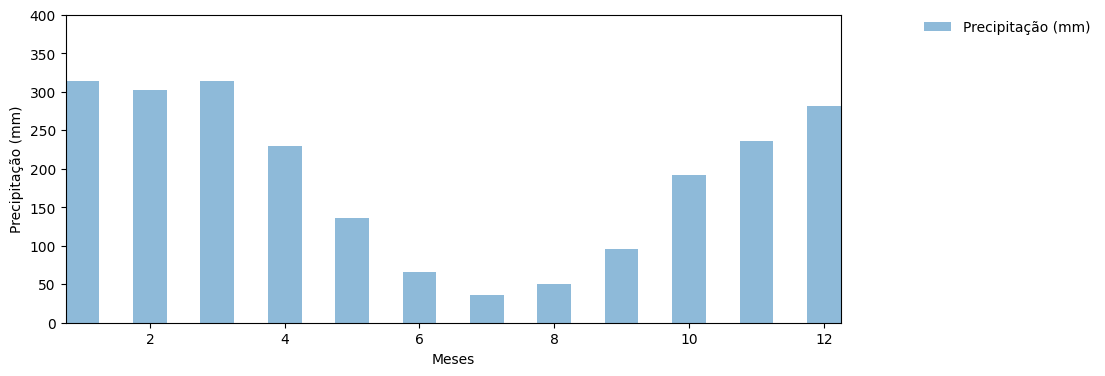

In [22]:
fig, ax1 = plt.subplots(figsize=(10,4))

ax1.margins(0.0)
ax1.bar(index_prec,P, width=0.5, label = 'Precipitação (mm)',alpha=0.5)

#plt.gcf().autofmt_xdate()
ax1.set_ylabel('Precipitação (mm)', fontsize=10) #y label
ax1.set_xlabel('Meses', fontsize=10) #y label
ax1.set_ylim(0, 400)

ax1.legend(bbox_to_anchor=(1.33, 0.9), borderaxespad=0.,frameon=False)

plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.,frameon=False)
plt.savefig('graficos/prec_clima.png', dpi = 300, bbox_inches='tight')
plt.show()

In [23]:
#1068000	966000	963001	867001	765000	770000	668000	567001

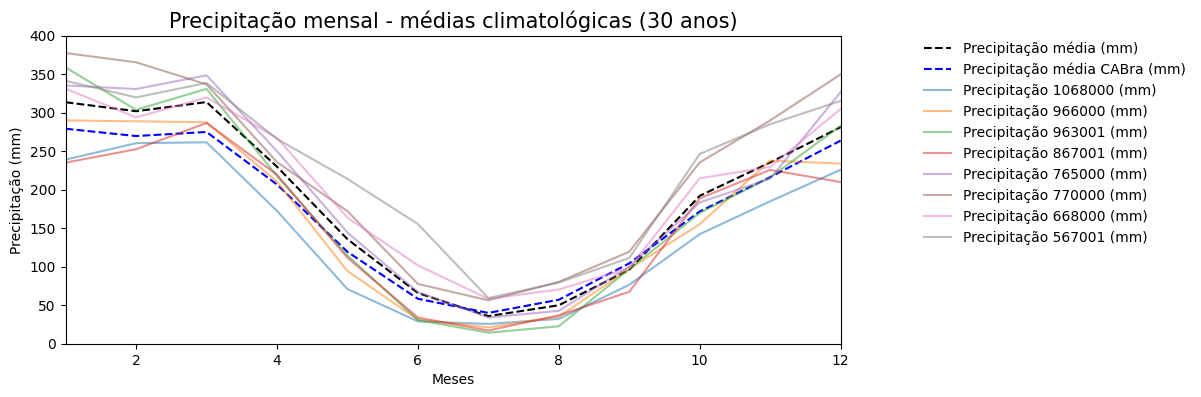

In [24]:
fig, ax1 = plt.subplots(figsize=(10,4))

ax1.margins(0.0)
ax1.plot(P, '--', label = 'Precipitação média (mm)', color='black')
ax1.plot(df_cabra_mensal['p_ens(mm)'], '--', label = 'Precipitação média CABra (mm)', color='blue')
ax1.plot(df_mensal['1068000'], label = 'Precipitação 1068000 (mm)',alpha=0.5)
ax1.plot(df_mensal['966000'], label = 'Precipitação 966000 (mm)',alpha=0.5)
ax1.plot(df_mensal['963001'], label = 'Precipitação 963001 (mm)',alpha=0.5)
ax1.plot(df_mensal['867001'], label = 'Precipitação 867001 (mm)',alpha=0.5)
ax1.plot(df_mensal['765000'], label = 'Precipitação 765000 (mm)',alpha=0.5)
ax1.plot(df_mensal['770000'], label = 'Precipitação 770000 (mm)',alpha=0.5)
ax1.plot(df_mensal['668000'], label = 'Precipitação 668000 (mm)',alpha=0.5)
ax1.plot(df_mensal['567001'], label = 'Precipitação 567001 (mm)',alpha=0.5)

#plt.gcf().autofmt_xdate()
ax1.set_ylabel('Precipitação (mm)', fontsize=10) #y label
ax1.set_xlabel('Meses', fontsize=10) #y label
ax1.set_ylim(0, 400)
ax1.legend(bbox_to_anchor=(1.33, 0.9), borderaxespad=0.,frameon=False)

plt.title('Precipitação mensal - médias climatológicas (30 anos)', fontsize=15) #y label
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.,frameon=False)
plt.savefig('graficos/prec_clima.png', dpi = 300, bbox_inches='tight')
plt.show()

# Espacialização da Precipitação


In [25]:
def grid_bounds(geom, delta):
    minx, miny, maxx, maxy = geom.bounds
    nx = int((maxx - minx)/delta)
    ny = int((maxy - miny)/delta)
    gx, gy = np.linspace(minx,maxx,nx), np.linspace(miny,maxy,ny)
    grid = []
    for i in range(len(gx)-1):
        for j in range(len(gy)-1):
            poly_ij = Polygon([[gx[i],gy[j]],[gx[i],gy[j+1]],[gx[i+1],gy[j+1]],[gx[i+1],gy[j]]])
            grid.append( poly_ij )
    return grid

In [26]:
def partition(geom, delta):
    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta)))
    return grid

In [27]:
bacia.geometry

0    MULTIPOLYGON (((-68.44875 -7.14875, -68.44708 ...
Name: geometry, dtype: geometry

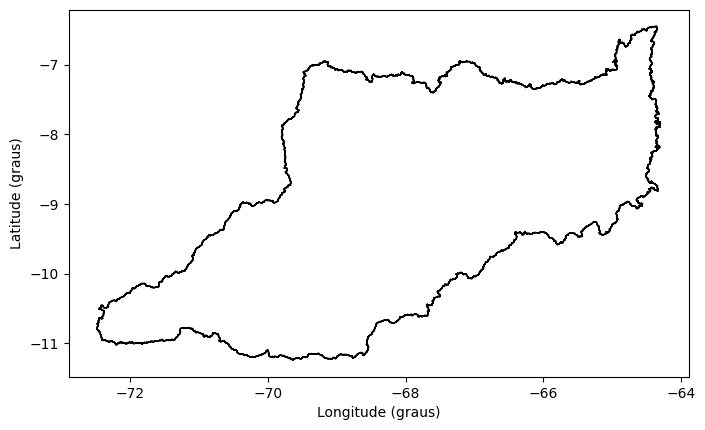

In [28]:
# Plot all the catchment and hidrometric station
fig, ax = plt.subplots(figsize=(8,6))
bacia.plot(ax=ax,color='white', edgecolor='black')
plt.xlabel('Longitude (graus)')
plt.ylabel('Latitude (graus)')
#plt.legend()
plt.show()

In [29]:
bacia_simples = bacia.simplify(0.3)

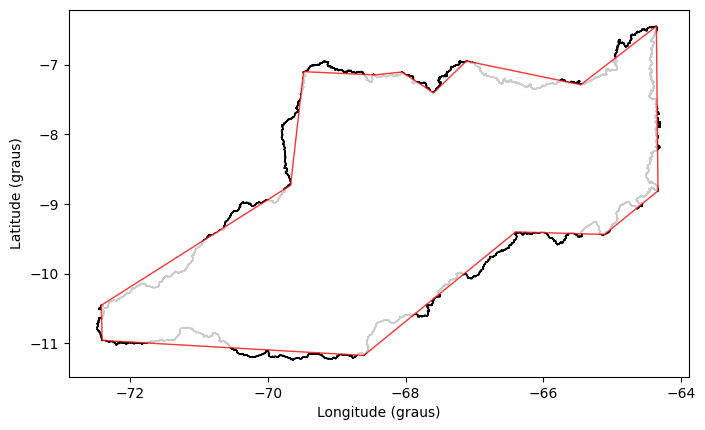

In [30]:
# Plot all the catchment and hidrometric station
fig, ax = plt.subplots(figsize=(8,6))
bacia.plot(ax=ax,color='white', edgecolor='black')
bacia_simples.plot(ax=ax,color='white', edgecolor='red',alpha=0.8)
plt.xlabel('Longitude (graus)')
plt.ylabel('Latitude (graus)')
#plt.legend()
plt.show()

In [31]:
g = json.loads(bacia_simples.to_json())

In [32]:
coords = g['features'][0]['geometry']['coordinates']
coords

[[[[-68.4487499994223, -7.148749999051633],
   [-68.44708324976324, -7.148749999227546],
   [-68.44708324909786, -7.150416749361426],
   [-68.44791674895062, -7.150416749630244],
   [-68.4487499994223, -7.148749999051633]]],
 [[[-65.10958325003543, -7.141249999754695],
   [-65.11041675047304, -7.141249999006319],
   [-65.11041675075873, -7.140416749669728],
   [-65.10958325004167, -7.140416749061439],
   [-65.10958325003543, -7.141249999754695]]],
 [[[-67.40541674867242, -7.107916749916192],
   [-67.40624999906134, -7.107916749800883],
   [-67.40624999867646, -7.107083249977858],
   [-67.40541674896276, -7.107083250021569],
   [-67.40541674867242, -7.107916749916192]]],
 [[[-68.4487499994223, -7.148749999051633],
   [-68.05708324967436, -7.107083250395178],
   [-67.59541674844891, -7.404583250276435],
   [-67.11791674980722, -6.949583248970554],
   [-65.45624999991732, -7.289583249036376],
   [-64.35791674965554, -6.45041674843601],
   [-64.33458324938928, -8.813749998792565],
   [-65.

In [33]:
coords[3]

[[[-68.4487499994223, -7.148749999051633],
  [-68.05708324967436, -7.107083250395178],
  [-67.59541674844891, -7.404583250276435],
  [-67.11791674980722, -6.949583248970554],
  [-65.45624999991732, -7.289583249036376],
  [-64.35791674965554, -6.45041674843601],
  [-64.33458324938928, -8.813749998792565],
  [-65.10958325010884, -9.438749999455958],
  [-66.40291674929071, -9.402916748843763],
  [-68.60791675065776, -11.176249998544076],
  [-72.40958324892306, -10.960416748316105],
  [-72.42291674943743, -10.456249999387145],
  [-69.67208324916601, -8.73291674982573],
  [-69.48458324905654, -7.102083248582102],
  [-68.4487499994223, -7.148749999051633]]]

In [34]:
np.array(coords[3]).squeeze()

array([[-68.44875   ,  -7.14875   ],
       [-68.05708325,  -7.10708325],
       [-67.59541675,  -7.40458325],
       [-67.11791675,  -6.94958325],
       [-65.45625   ,  -7.28958325],
       [-64.35791675,  -6.45041675],
       [-64.33458325,  -8.81375   ],
       [-65.10958325,  -9.43875   ],
       [-66.40291675,  -9.40291675],
       [-68.60791675, -11.17625   ],
       [-72.40958325, -10.96041675],
       [-72.42291675, -10.45625   ],
       [-69.67208325,  -8.73291675],
       [-69.48458325,  -7.10208325],
       [-68.44875   ,  -7.14875   ]])

In [35]:
bacia_simples2 = Polygon([[-68.4487499994223, -7.148749999051633],
  [-68.05708324967436, -7.107083250395178],
  [-67.59541674844891, -7.404583250276435],
  [-67.11791674980722, -6.949583248970554],
  [-65.45624999991732, -7.289583249036376],
  [-64.35791674965554, -6.45041674843601],
  [-64.33458324938928, -8.813749998792565],
  [-65.10958325010884, -9.438749999455958],
  [-66.40291674929071, -9.402916748843763],
  [-68.60791675065776, -11.176249998544076],
  [-72.40958324892306, -10.960416748316105],
  [-72.42291674943743, -10.456249999387145],
  [-69.67208324916601, -8.73291674982573],
  [-69.48458324905654, -7.102083248582102],
  [-68.4487499994223, -7.148749999051633]])

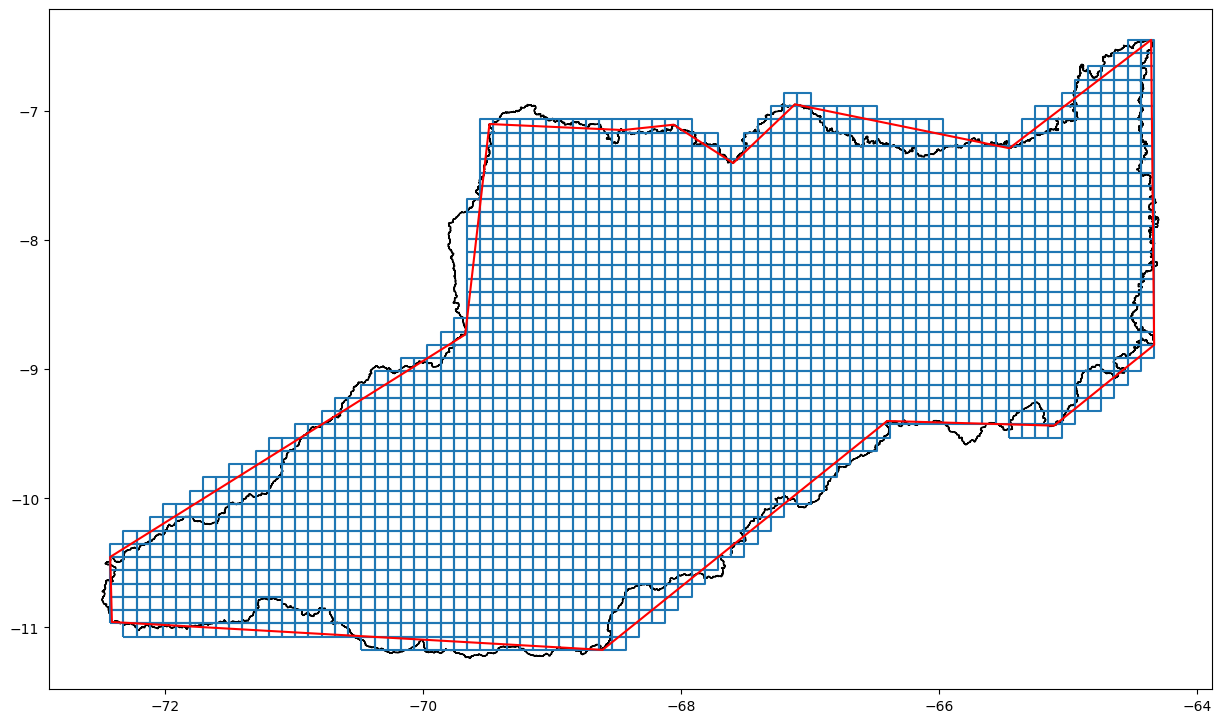

In [36]:
geom = bacia_simples2
grid = partition(geom, 0.1)

fig, ax = plt.subplots(figsize=(15, 15))
bacia.plot(ax=ax,color='white', edgecolor='black')
gpd.GeoSeries(grid).boundary.plot(ax=ax)
gpd.GeoSeries([geom]).boundary.plot(ax=ax,color="red")
plt.show()

In [37]:
len(grid)

1999

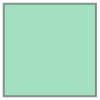

In [38]:
grid[0]

In [39]:
grid[0].centroid.xy

(array('d', [-72.3717247652599]), array('d', [-10.919411234951246]))

In [40]:
x_grid = grid[0].centroid.xy[0][0]
y_grid = grid[0].centroid.xy[1][0]
x_grid, y_grid

(-72.3717247652599, -10.919411234951246)

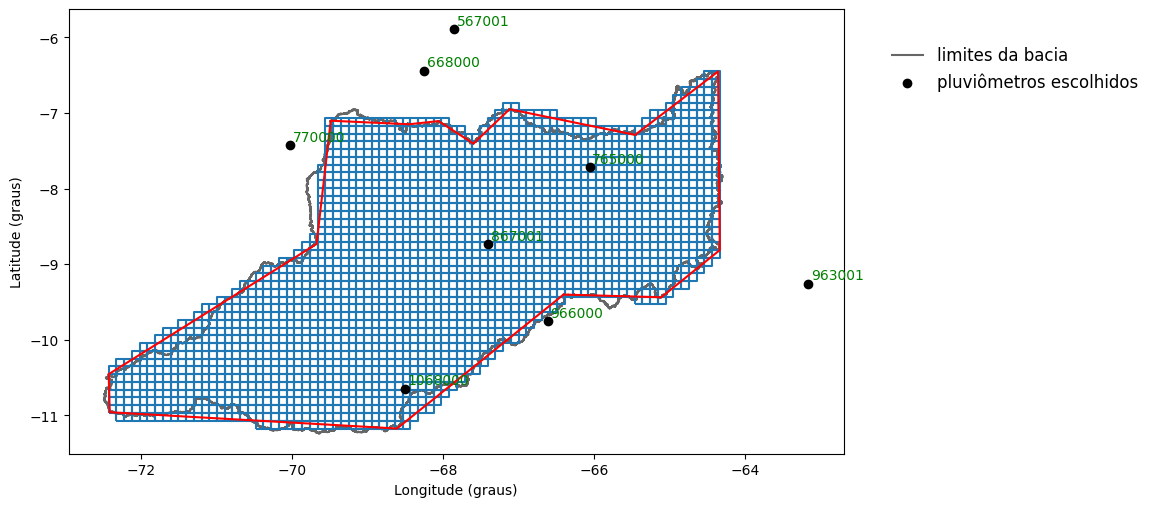

In [41]:
fig, ax = plt.subplots(figsize = (10, 6))

bacia.geometry.boundary.plot(ax = ax, alpha = 0.6, color = None, edgecolor =  "black", label = 'limites da bacia',zorder=0)
#hidro.plot(ax=ax,color='blue', linewidth=0.2, label = 'hidrografia',zorder=1)

gpd.GeoSeries(grid).boundary.plot(ax=ax,zorder=1)
gpd.GeoSeries([geom]).boundary.plot(ax=ax,color="red",zorder=1)

ax.scatter(pluvio_sel["lon"], pluvio_sel["lat"], color = "black", label = 'pluviômetros escolhidos',zorder=2)
for i, (x,y) in enumerate(zip (pluvio_sel["lon"], pluvio_sel["lat"])):
    label = pluvio_sel["name"][i]
    ax.annotate(label, (x,y), textcoords = "offset points", xytext = (2,3), color = "green")

plt.xlabel('Longitude (graus)')
plt.ylabel('Latitude (graus)')

plt.legend(loc="upper right",bbox_to_anchor=(1.4, 0.95), frameon=False, fontsize=12)

# Show the plot
plt.savefig('pluviometros_escolhidos.png', dpi = 100, bbox_inches='tight')
#plt.savefig('Mutations_bars_correlation.pdf', dpi = 600, bbox_inches='tight')
plt.show();


In [42]:
df_lista_pluv = pd.DataFrame(pluvio_sel)
df_lista_pluv

,CODIGO,lon,lat,name,geometry
0,1068000,-68.5067,-10.6497,1068000,POINT (-68.50670 -10.64970)
1,966000,-66.6117,-9.7556,966000,POINT (-66.61170 -9.75560)
2,963001,-63.1619,-9.2606,963001,POINT (-63.16190 -9.26060)
3,867001,-67.4003,-8.7356,867001,POINT (-67.40030 -8.73560)
4,765000,-66.0583,-7.7156,765000,POINT (-66.05830 -7.71560)
5,770000,-70.0225,-7.4281,770000,POINT (-70.02250 -7.42810)
6,668000,-68.2439,-6.4417,668000,POINT (-68.24390 -6.44170)
7,567001,-67.8569,-5.8936,567001,POINT (-67.85690 -5.89360)


In [43]:
def encontra_pluv_mais_proximo(grid_x, grid_y,df_lista_pluv):
  # Pluviômetros que estão próximos ao ponto do grid
  possiveis = df_lista_pluv

  x = grid_x
  y = grid_y
  #print(x,y)

  lista_x = possiveis['lon'].values
  lista_y = possiveis['lat'].values
  #print(lista_x,lista_y)

  # Calcula a distância de cada pluviômetro e armazena na lista d
  d = []
  for i in range(len(possiveis)):
    d.append(np.sqrt((x-lista_x[i])**2+(y-lista_y[i])**2))

  possiveis['distancia'] = np.array(d)
  proximos = possiveis.sort_values(by=['distancia'])
  proximos = proximos.reset_index()
  return proximos['CODIGO'][0]

In [44]:
pluv_mais_prox = encontra_pluv_mais_proximo(x_grid, y_grid,df_lista_pluv)
pluv_mais_prox

1068000

In [45]:
lista_pluv_para_thiessen = []

for i in range(len(grid)):
  # percorre todos os pontos do grid e extrai as coordenadas do centróide
  x_grid = grid[i].centroid.xy[0][0]
  y_grid = grid[i].centroid.xy[1][0]
  #print(x_grid, y_grid)

  pluv_mais_prox = encontra_pluv_mais_proximo(x_grid, y_grid,df_lista_pluv)
  #print(pluv_mais_prox)
  lista_pluv_para_thiessen.append(pluv_mais_prox)

In [46]:
# Python Set() to Get Unique Values from a List
set(lista_pluv_para_thiessen)

{668000, 765000, 770000, 867001, 963001, 966000, 1068000}

# Obter o número de vezes que cada pluviômetro apareceu na lista

## Obtendo os pesos do Método de Thiessen

In [47]:
from collections import Counter

In [48]:
n = dict(Counter(lista_pluv_para_thiessen))
n

{1068000: 647,
 770000: 239,
 867001: 373,
 668000: 87,
 966000: 159,
 765000: 458,
 963001: 36}

In [49]:
647+239+373+87+159+458+36

1999

In [50]:
peso_1068000 = 647/1999
peso_770000  = 239/1999
peso_867001  = 373/1999
peso_668000  =  87/1999
peso_966000  = 159/1999
peso_765000  = 458/1999
peso_963001  =  36/1999

In [51]:
df_pluv['media thiessen'] = (peso_1068000*df_pluv['1068000'] +
                             peso_770000*df_pluv['770000'] +
                             peso_867001*df_pluv['867001'] +
                             peso_668000*df_pluv['668000'] +
                             peso_966000*df_pluv['966000'] +
                             peso_765000*df_pluv['765000'] +
                             peso_963001*df_pluv['963001'] )

In [55]:
df_pluv['media aritmetica'] = df_pluv.mean(axis=1)
df_pluv

,1068000,966000,963001,867001,765000,770000,668000,567001,media thiessen,media aritmetica
data,,,,,,,,,,
1980-01-01,20.5,20.6,0.0,18.0,15.2,0.0,30.4,4.4,16.437869,13.948652
1980-01-02,0.0,0.0,0.0,0.0,16.4,0.0,0.0,22.6,3.757479,4.750831
1980-01-03,0.0,0.0,2.2,0.0,0.0,0.0,0.0,23.8,0.039620,2.893291
1980-01-04,0.0,1.0,6.4,14.0,0.0,10.3,0.0,0.0,4.038569,3.970952
1980-01-05,0.0,1.2,0.6,0.0,5.2,21.1,0.0,0.0,3.820360,3.546707
...,...,...,...,...,...,...,...,...,...,...
2010-12-27,0.0,0.0,0.0,3.1,1.6,0.0,11.3,56.3,1.436818,8.192980
2010-12-28,0.0,66.2,39.0,0.0,0.7,0.0,0.0,41.0,6.128264,17.003140
2010-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.000000,3.666667


In [56]:
df = df_pluv.copy()
# acumula mensalmente
df_mensal = df.resample('M').sum()
df_mensal['month'] = df_mensal.index.month
# agrupa por mês e tira a média de todos os anos
df_mensal = df_mensal.groupby('month').mean()
df_mensal

,1068000,966000,963001,867001,765000,770000,668000,567001,media thiessen,media aritmetica
month,,,,,,,,,,
1,239.116129,289.996774,358.800000,235.200000,335.403226,377.519355,331.212903,341.409677,287.204276,310.651371
2,260.432258,288.841935,303.732258,252.590323,330.758065,365.477419,293.922581,319.883871,292.137895,300.864067
3,261.603226,287.625806,331.029032,286.661290,348.609677,336.854839,319.800000,338.641935,301.063349,312.432128
4,172.445161,210.377419,217.612903,219.493548,250.045161,235.893548,267.419355,265.883871,214.553233,228.191578
5,70.951613,94.441935,114.677419,111.609677,144.367742,172.122581,163.709677,214.035484,114.147685,133.340424
6,28.993548,31.341935,30.770968,33.961290,66.980645,77.606452,101.764516,155.390323,47.821961,63.847960
7,25.687097,21.270968,14.280645,17.222581,34.045161,56.387097,58.303226,59.280645,30.555949,35.225930
8,32.251613,35.212903,22.638710,36.877419,42.735484,80.325806,70.396774,79.451613,42.987071,49.208599
9,76.577419,97.200000,97.022581,67.480645,100.309677,119.516129,98.409677,111.383871,88.409861,95.145540


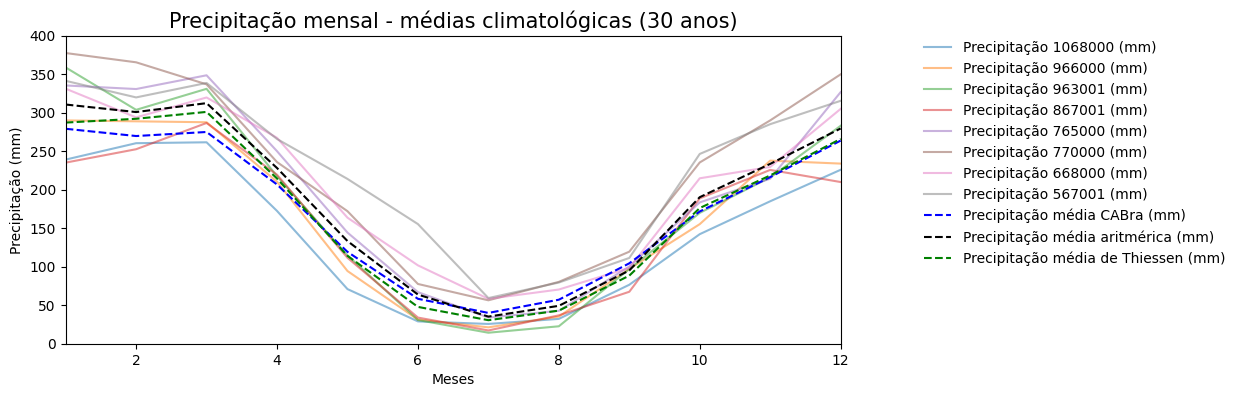

In [57]:
fig, ax1 = plt.subplots(figsize=(10,4))

ax1.margins(0.0)

ax1.plot(df_mensal['1068000'], label = 'Precipitação 1068000 (mm)',alpha=0.5)
ax1.plot(df_mensal['966000'], label = 'Precipitação 966000 (mm)',alpha=0.5)
ax1.plot(df_mensal['963001'], label = 'Precipitação 963001 (mm)',alpha=0.5)
ax1.plot(df_mensal['867001'], label = 'Precipitação 867001 (mm)',alpha=0.5)
ax1.plot(df_mensal['765000'], label = 'Precipitação 765000 (mm)',alpha=0.5)
ax1.plot(df_mensal['770000'], label = 'Precipitação 770000 (mm)',alpha=0.5)
ax1.plot(df_mensal['668000'], label = 'Precipitação 668000 (mm)',alpha=0.5)
ax1.plot(df_mensal['567001'], label = 'Precipitação 567001 (mm)',alpha=0.5)

ax1.plot(df_cabra_mensal['p_ens(mm)'], '--', label = 'Precipitação média CABra (mm)', color='blue')
ax1.plot(df_mensal['media aritmetica'], '--', label = 'Precipitação média aritmérica (mm)', color='black')
ax1.plot(df_mensal['media thiessen'], '--', label = 'Precipitação média de Thiessen (mm)', color='green')


#plt.gcf().autofmt_xdate()
ax1.set_ylabel('Precipitação (mm)', fontsize=10) #y label
ax1.set_xlabel('Meses', fontsize=10) #y label
ax1.set_ylim(0, 400)
ax1.legend(bbox_to_anchor=(1.33, 0.9), borderaxespad=0.,frameon=False)

plt.title('Precipitação mensal - médias climatológicas (30 anos)', fontsize=15) #y label
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.,frameon=False)
plt.savefig('graficos/prec_clima.png', dpi = 300, bbox_inches='tight')
plt.show()

<Axes: xlabel='data'>

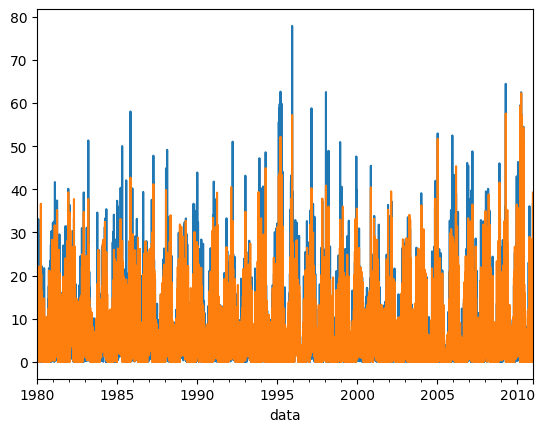

In [58]:
df_pluv['media thiessen'].plot()
df_pluv['media aritmetica'].plot()

<Axes: xlabel='data'>

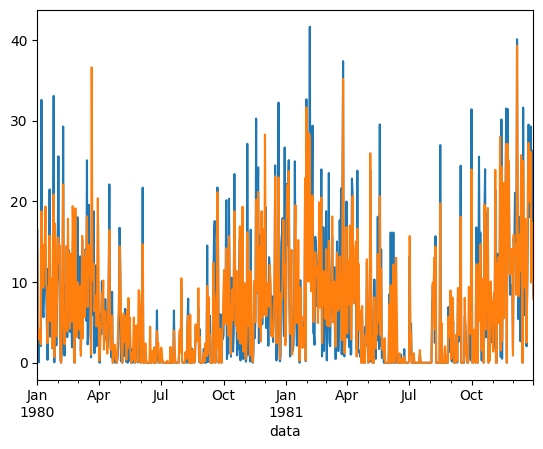

In [59]:
df_pluv['media thiessen']['1980':'1981'].plot()
df_pluv['media aritmetica']['1980':'1981'].plot()

# Ilustrando o método através do mapa

In [60]:
grid_1068000 = []
grid_770000  = []
grid_867001  = []
grid_668000  = []
grid_966000  = []
grid_765000  = []
grid_963001  = []

for i in range(len(grid)):
  # percorre todos os pontos do grid e extrai as coordenadas do centróide
  x_grid = grid[i].centroid.xy[0][0]
  y_grid = grid[i].centroid.xy[1][0]
  #print(x_grid, y_grid)

  pluv_mais_prox = encontra_pluv_mais_proximo(x_grid, y_grid,df_lista_pluv)
  #print(pluv_mais_prox)

  if pluv_mais_prox == 1068000:
    grid_1068000.append(grid[i])
  elif pluv_mais_prox == 770000:
    grid_770000.append(grid[i])
  elif pluv_mais_prox == 867001:
    grid_867001.append(grid[i])
  elif pluv_mais_prox == 668000:
    grid_668000.append(grid[i])
  elif pluv_mais_prox == 966000:
    grid_966000.append(grid[i])
  elif pluv_mais_prox == 765000:
    grid_765000.append(grid[i])
  else:
    grid_963001.append(grid[i])

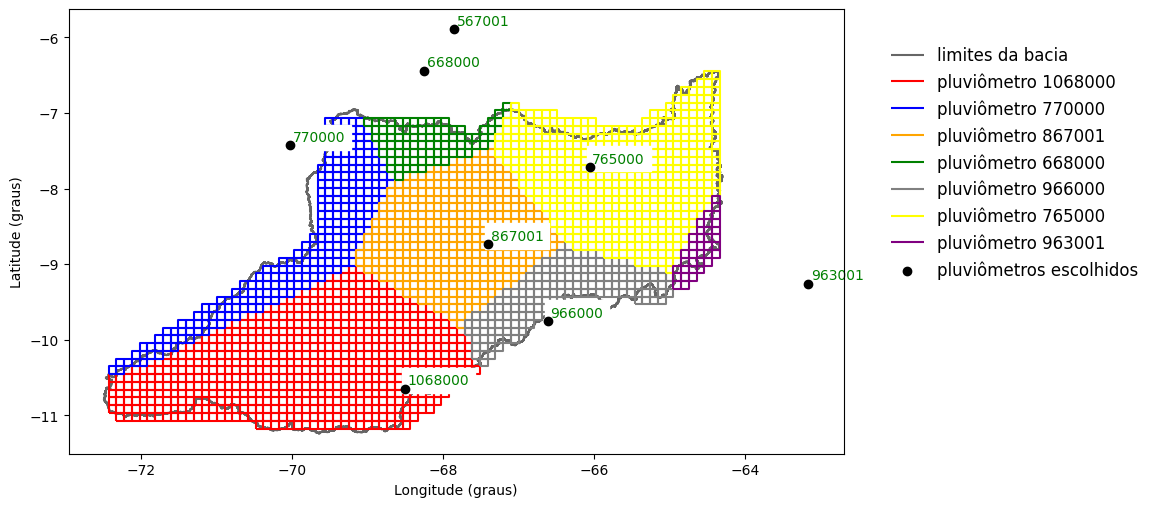

In [61]:
fig, ax = plt.subplots(figsize = (10, 6))

bacia.geometry.boundary.plot(ax = ax, alpha = 0.6, color = None, edgecolor =  "black", label = 'limites da bacia',zorder=0)
#hidro.plot(ax=ax,color='blue', linewidth=0.2, label = 'hidrografia',zorder=1)

gpd.GeoSeries(grid_1068000).boundary.plot(ax=ax,color="red",zorder=1, label = 'pluviômetro 1068000')
gpd.GeoSeries(grid_770000).boundary.plot(ax=ax,color="blue",zorder=1, label = 'pluviômetro 770000')
gpd.GeoSeries(grid_867001).boundary.plot(ax=ax,color="orange",zorder=1, label = 'pluviômetro 867001')
gpd.GeoSeries(grid_668000).boundary.plot(ax=ax,color="green",zorder=1, label = 'pluviômetro 668000')
gpd.GeoSeries(grid_966000).boundary.plot(ax=ax,color="gray",zorder=1, label = 'pluviômetro 966000')
gpd.GeoSeries(grid_765000).boundary.plot(ax=ax,color="yellow",zorder=1, label = 'pluviômetro 765000')
gpd.GeoSeries(grid_963001).boundary.plot(ax=ax,color="purple",zorder=1, label = 'pluviômetro 963001')
#gpd.GeoSeries([geom]).boundary.plot(ax=ax,color="red",zorder=1)

for i, (x,y) in enumerate(zip (pluvio_sel["lon"], pluvio_sel["lat"])):
    label = pluvio_sel["name"][i]
    ax.annotate(label, (x,y), textcoords = "offset points", xytext = (2,3),  backgroundcolor="w", color = "green",zorder=2)
ax.scatter(pluvio_sel["lon"], pluvio_sel["lat"], color = "black", label = 'pluviômetros escolhidos',zorder=3)


plt.xlabel('Longitude (graus)')
plt.ylabel('Latitude (graus)')

plt.legend(loc="upper right",bbox_to_anchor=(1.4, 0.95), frameon=False, fontsize=12)

# Show the plot
plt.savefig('thiessen_grid.png', dpi = 200, bbox_inches='tight')
#plt.savefig('thiessen_grid.pdf', dpi = 600, bbox_inches='tight')
plt.show();
